In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# instantiation of required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import missingno as msno

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.metrics import roc_auc_score, classification_report, f1_score, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
# installing catboost
!pip install catboost

In [5]:
# Installing the most recent version of skopt directly from Github
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-14kat6mg
  Running command git clone -q https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-14kat6mg
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/15/c4/1310a054d33abc318426a956e7d6df0df76a6ddfa9c66f6310274fb75d42/pyaml-20.4.0-py2.py3-none-any.whl
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.dev0-cp37-none-any.whl size=102003 sha256=9336a4c6ea94e031c8ec1bb448c410fc01b3be5a0421fceca314d1445dd6207f
  Stored in directory: /tmp/pip-ephem-wheel-cache-uew85c2y/wheels/11/6f/86/2b772172db85ad0b4487d67e325e535ee8e7782b2a1dfcadf5
Successfully built scikit-optimize


In [6]:
from time import time
import pprint
import joblib

# Classifiers
from catboost import CatBoostClassifier

# Model selection
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer

In [7]:
cd /content/drive/MyDrive/Hackathon/HILP

/content/drive/MyDrive/Hackathon/HILP


In [8]:
data = pd.read_csv("train_Df64byy.csv")
data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [9]:
test_df = pd.read_csv('test_YCcRUnU.csv')
test_df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


In [10]:
data.shape # shape of the dataset

(50882, 14)

In [11]:
test_df.shape

(21805, 13)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

Datatypes of the following columns are incorrect:
- Region_Code
- Holding_Policy_Type
- Reco_Policy_Cat

Needs to be of **object** or **categorical**

In [13]:
# change datatype of the above columns
cols = ['Region_Code', 'Holding_Policy_Type', 'Reco_Policy_Cat']
data[cols] = data[cols].astype('object')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  object 
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  object 
 11  Reco_Policy_Cat          50882 non-null  object 
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(1), int64(4

In [14]:
cols = ['Region_Code', 'Holding_Policy_Type', 'Reco_Policy_Cat'] # test side 

test_df[cols] = test_df[cols].astype('object')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21805 entries, 0 to 21804
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       21805 non-null  int64  
 1   City_Code                21805 non-null  object 
 2   Region_Code              21805 non-null  object 
 3   Accomodation_Type        21805 non-null  object 
 4   Reco_Insurance_Type      21805 non-null  object 
 5   Upper_Age                21805 non-null  int64  
 6   Lower_Age                21805 non-null  int64  
 7   Is_Spouse                21805 non-null  object 
 8   Health Indicator         16778 non-null  object 
 9   Holding_Policy_Duration  13202 non-null  object 
 10  Holding_Policy_Type      13202 non-null  object 
 11  Reco_Policy_Cat          21805 non-null  object 
 12  Reco_Policy_Premium      21805 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 2.2+ MB


In [15]:
data.duplicated().sum() #  check for duplicate observation

0

All observations are unique.

In [16]:
len(data['ID'].unique())

50882

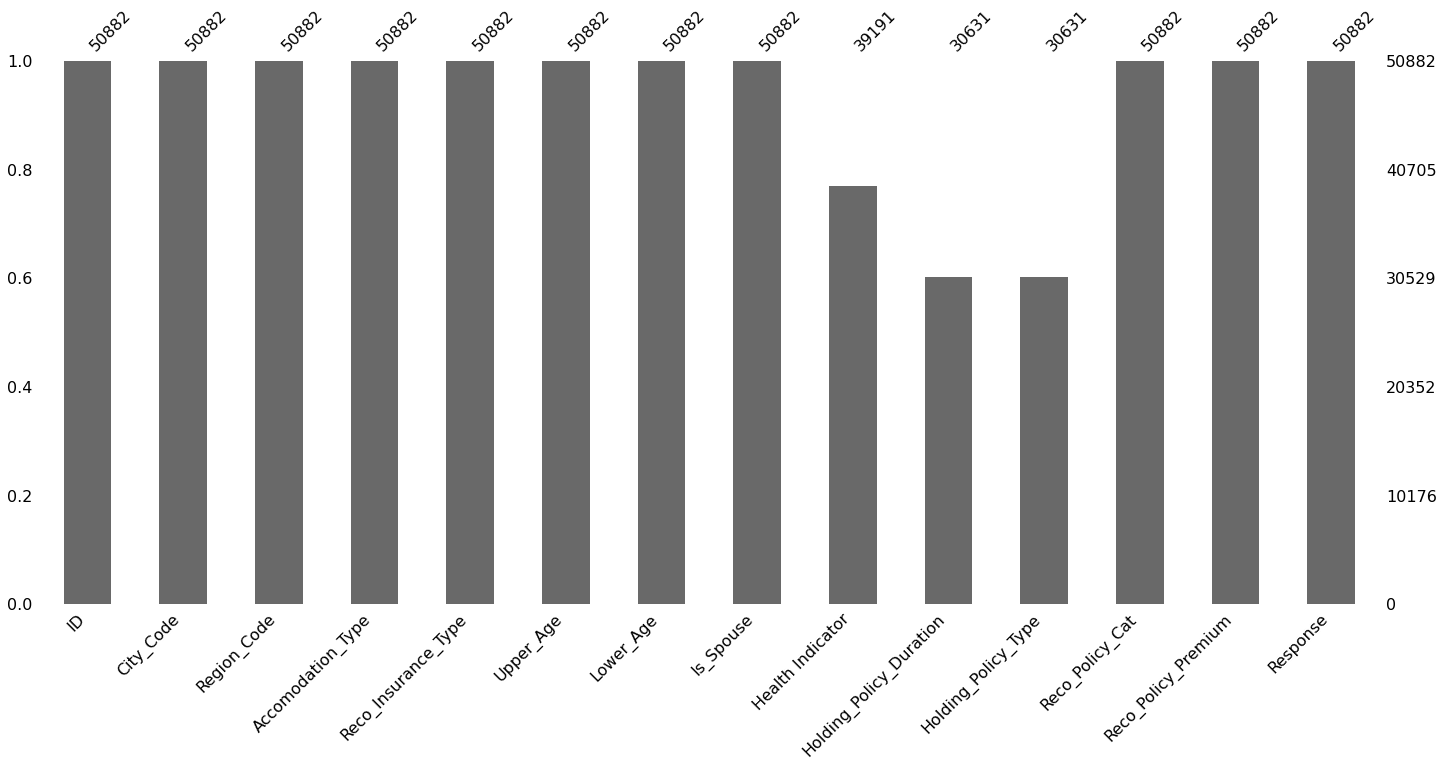

In [17]:
# visualizing missing values using bar plot
msno.bar(data)

Presence of missing values in following columns:
- Health Indicator
- Holding Policy Duration
- Holding policy type

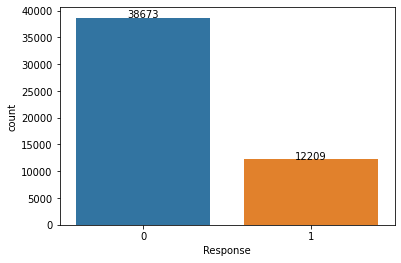

In [18]:
graph = sns.countplot('Response', data=data);
graph.set_xticklabels(graph.get_xticklabels())
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        data['Response'].value_counts()[i],ha="center")
    i += 1

Looks like data is **imbalanced**. Proportion of customers who show interest in recommended policy are **12209** out of **50882**. 
- 0 - Customer did not show interest in the recommended policy
- 1 - Customer showed interest in the recommended policy

In [19]:
# some statistical description
data.iloc[:,1:].describe()

,Upper_Age,Lower_Age,Reco_Policy_Premium,Response
count,50882.000000,50882.000000,50882.000000,50882.000000
mean,44.856275,42.738866,14183.950069,0.239947
std,17.310271,17.319375,6590.074873,0.427055
min,18.000000,16.000000,2280.000000,0.000000
25%,28.000000,27.000000,9248.000000,0.000000
50%,44.000000,40.000000,13178.000000,0.000000
75%,59.000000,57.000000,18096.000000,0.000000
max,75.000000,75.000000,43350.400000,1.000000


### Missing Value 

In [20]:
data.isnull().sum() #count of missing values

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

In [21]:
#those who don't have any policy type for them duration is also missing 
# that's why filling those by zero 
data['Holding_Policy_Duration'].fillna(0,inplace=True)
data['Holding_Policy_Type'].fillna(-1, inplace=True)
data['Health Indicator'].fillna("unknown",inplace=True)

In [22]:
test_df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


In [23]:
# on test side
test_df['Holding_Policy_Duration'].fillna(0,inplace=True)
test_df['Holding_Policy_Type'].fillna(-1, inplace=True)
test_df['Health Indicator'].fillna("unknown",inplace=True)

In [24]:
data['Cust_type'] = data['Holding_Policy_Duration'].apply(lambda x: 0 if x==0 else 1)

In [25]:
test_df['Cust_type'] = test_df['Holding_Policy_Duration'].apply(lambda x: 0 if x==0 else 1)

In [26]:
test_df.shape, data.shape

((21805, 14), (50882, 15))

### Feature Tools 

In [27]:
!pip install featuretools # installing a library 

     |████████████████████████████████| 296kB 9.1MB/s 
     |████████████████████████████████| 675kB 15.2MB/s 
     |████████████████████████████████| 112kB 24.8MB/s 
ERROR: distributed 2021.2.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.2.0 has requirement dask>=2021.02.0, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3


In [28]:
# instantiation
import featuretools.variable_types as vtypes
import featuretools as ft

In [29]:
# Average Age
data["Avg_Age"] = round((data.Upper_Age + data.Lower_Age) / 2)
# age difference
data["Age_diff"] = data.Upper_Age - data.Lower_Age
# log transform
data["Reco_Policy_Premium"] = np.log(data["Reco_Policy_Premium"])

In [30]:
# Average Age
test_df["Avg_Age"] = round((test_df.Upper_Age + test_df.Lower_Age) / 2)
# age difference
test_df["Age_diff"] = test_df.Upper_Age - test_df.Lower_Age
# log transform
test_df["Reco_Policy_Premium"] = np.log(test_df["Reco_Policy_Premium"])

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  object 
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         50882 non-null  object 
 9   Holding_Policy_Duration  50882 non-null  object 
 10  Holding_Policy_Type      50882 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  object 
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
 14  Cust_type             

In [32]:
#datatype change to sting from object datatype
for col in data.columns:
  if data[col].dtype == 'object':
    data[col] = data[col].astype(str)

# for test_df
for i in test_df.columns:
  if test_df[i].dtype == 'object':
    test_df[i] = test_df[i].astype(str)

In [33]:
feature_eng = data.copy()
#test
feature_eng_test = test_df.copy()

feature_eng.drop("Response",axis=1, inplace=True)

feature_eng["common_id"] = feature_eng["City_Code"].astype(str) + feature_eng.Region_Code.astype(str)

#test
feature_eng_test["common_id"] = feature_eng_test["City_Code"].astype(str) + feature_eng_test.Region_Code.astype(str)

In [34]:
variable_types = {'Upper_Age': vtypes.Ordinal,
                  'Lower_Age': vtypes.Ordinal,
                  }

In [35]:
es = ft.EntitySet('Health') # any random name of godown
es = es.entity_from_dataframe(entity_id="health",
                              dataframe=feature_eng,
                              index='ID',
                              variable_types=variable_types)
es['health']

Entity: health
  Variables:
    ID (dtype: index)
    City_Code (dtype: categorical)
    Region_Code (dtype: categorical)
    Accomodation_Type (dtype: categorical)
    Reco_Insurance_Type (dtype: categorical)
    Is_Spouse (dtype: categorical)
    Health Indicator (dtype: categorical)
    Holding_Policy_Duration (dtype: categorical)
    Holding_Policy_Type (dtype: numeric)
    Reco_Policy_Cat (dtype: categorical)
    Reco_Policy_Premium (dtype: numeric)
    Cust_type (dtype: numeric)
    Avg_Age (dtype: numeric)
    Age_diff (dtype: numeric)
    common_id (dtype: categorical)
    Upper_Age (dtype: ordinal)
    Lower_Age (dtype: ordinal)
  Shape:
    (Rows: 50882, Columns: 17)

In [36]:
#test
es_test = ft.EntitySet('Health')
es_test = es_test.entity_from_dataframe(entity_id="health",
                              dataframe=feature_eng_test,
                              index='ID',
                              variable_types=variable_types)
es_test['health']

Entity: health
  Variables:
    ID (dtype: index)
    City_Code (dtype: categorical)
    Region_Code (dtype: categorical)
    Accomodation_Type (dtype: categorical)
    Reco_Insurance_Type (dtype: categorical)
    Is_Spouse (dtype: categorical)
    Health Indicator (dtype: categorical)
    Holding_Policy_Duration (dtype: categorical)
    Holding_Policy_Type (dtype: numeric)
    Reco_Policy_Cat (dtype: categorical)
    Reco_Policy_Premium (dtype: numeric)
    Cust_type (dtype: numeric)
    Avg_Age (dtype: numeric)
    Age_diff (dtype: numeric)
    common_id (dtype: categorical)
    Upper_Age (dtype: ordinal)
    Lower_Age (dtype: ordinal)
  Shape:
    (Rows: 21805, Columns: 17)

In [37]:
# Make a relationship entity with another specific variables
es.normalize_entity('health', 'insurence', 'common_id',
                    additional_variables=['Health Indicator',
                                          'Holding_Policy_Duration',
                                          'Holding_Policy_Type',
                                          'Cust_type',
                                          'Reco_Policy_Premium'])

#es.normalize_entity('health', 'city', 'City_Code')
#es.normalize_entity('health', 'region', 'Region_Code')
#es.normalize_entity('health', 'ages', 'Upper_Age')
#es.normalize_entity('health', 'married', 'Is_Spouse')
#es.normalize_entity('health', 'married', 'Is_Spouse')

Entityset: Health
  Entities:
    health [Rows: 50882, Columns: 12]
    insurence [Rows: 5297, Columns: 6]
  Relationships:
    health.common_id -> insurence.common_id

In [38]:
# test
es_test.normalize_entity('health', 'insurence', 'common_id',
                    additional_variables=['Health Indicator',
                                          'Holding_Policy_Duration',
                                          'Holding_Policy_Type',
                                          'Cust_type',
                                          'Reco_Policy_Premium'])

Entityset: Health
  Entities:
    health [Rows: 21805, Columns: 12]
    insurence [Rows: 4675, Columns: 6]
  Relationships:
    health.common_id -> insurence.common_id

In [39]:
# Show the entity
es['insurence'].df.head(2)


,common_id,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Cust_type,Reco_Policy_Premium
C33213,C33213,X1,14+,3.0,1,9.361171
C51117,C51117,X2,0,-1.0,0,10.325810


In [40]:
#test
es_test['insurence'].df.head(2)

,common_id,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Cust_type,Reco_Policy_Premium
C1156,C1156,unknown,6.0,3.0,1,9.387147
C47,C47,X1,3.0,3.0,1,10.379871


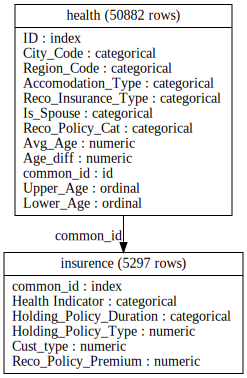

In [41]:
es.plot()

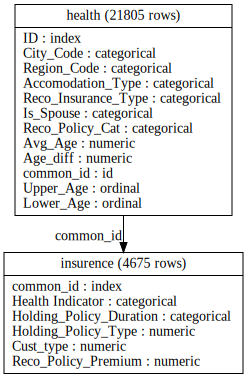

In [42]:
es_test.plot()

In [43]:
fm, features = ft.dfs(entityset=es, target_entity='health',max_depth=5,
                      approximate='6h',verbose=True)

Built 45 features
Elapsed: 00:09 | Progress: 100%|██████████


In [44]:
#test
fm_test, features_test = ft.dfs(entityset=es_test, target_entity='health',max_depth=5,
                      approximate='6h',verbose=True)

Built 45 features
Elapsed: 00:07 | Progress: 100%|██████████


In [45]:
fm.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,Reco_Policy_Cat,Avg_Age,Age_diff,common_id,Upper_Age,Lower_Age,insurence.Health Indicator,insurence.Holding_Policy_Duration,insurence.Holding_Policy_Type,insurence.Cust_type,insurence.Reco_Policy_Premium,insurence.COUNT(health),insurence.MAX(health.Age_diff),insurence.MAX(health.Avg_Age),insurence.MEAN(health.Age_diff),insurence.MEAN(health.Avg_Age),insurence.MIN(health.Age_diff),insurence.MIN(health.Avg_Age),insurence.MODE(health.Accomodation_Type),insurence.MODE(health.City_Code),insurence.MODE(health.Is_Spouse),insurence.MODE(health.Lower_Age),insurence.MODE(health.Reco_Insurance_Type),insurence.MODE(health.Reco_Policy_Cat),insurence.MODE(health.Region_Code),insurence.MODE(health.Upper_Age),insurence.NUM_UNIQUE(health.Accomodation_Type),insurence.NUM_UNIQUE(health.City_Code),insurence.NUM_UNIQUE(health.Is_Spouse),insurence.NUM_UNIQUE(health.Lower_Age),insurence.NUM_UNIQUE(health.Reco_Insurance_Type),insurence.NUM_UNIQUE(health.Reco_Policy_Cat),insurence.NUM_UNIQUE(health.Region_Code),insurence.NUM_UNIQUE(health.Upper_Age),insurence.SKEW(health.Age_diff),insurence.SKEW(health.Avg_Age),insurence.STD(health.Age_diff),insurence.STD(health.Avg_Age),insurence.SUM(health.Age_diff),insurence.SUM(health.Avg_Age)
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,C3,3213,Rented,Individual,No,22,36.0,0,C33213,36,36,X1,14+,3.0,1,9.361171,8,2,72.0,0.250000,41.750000,0,25.0,Rented,C3,No,25,Individual,21,3213,25,2,1,2,8,2,5,1,8,2.828427,0.912549,0.707107,17.119329,2,334.0
2,C5,1117,Owned,Joint,No,22,48.0,53,C51117,75,22,X2,0,-1.0,0,10.325810,17,53,70.0,6.705882,39.823529,0,22.0,Owned,C5,No,37,Individual,22,1117,26,2,1,2,13,2,4,1,14,2.620804,0.805396,14.848252,14.531153,114,677.0
3,C5,3732,Owned,Individual,No,19,32.0,0,C53732,32,32,unknown,1.0,1.0,1,8.915969,7,2,75.0,0.285714,35.285714,0,23.0,Rented,C5,No,23,Individual,1,3732,30,2,1,2,7,2,2,1,6,2.645751,2.372730,0.755929,17.960274,2,247.0
4,C24,4378,Owned,Joint,No,19,50.0,4,C244378,52,48,X1,14+,3.0,1,9.785830,5,4,56.0,0.800000,48.000000,0,28.0,Owned,C24,No,53,Individual,2,4378,53,1,1,1,4,2,4,1,4,2.236068,-2.044195,1.788854,11.379807,4,240.0
5,C8,2190,Rented,Individual,No,16,44.0,0,C82190,44,44,X2,3.0,1.0,1,9.249946,11,30,73.0,7.000000,41.818182,0,28.0,Owned,C8,No,19,Joint,16,2190,33,2,1,2,9,2,3,1,7,1.751014,1.429884,11.610340,13.098230,77,460.0


In [46]:
remove_cols = ['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Is_Spouse', 'Reco_Policy_Cat', 'Age_diff', 'common_id', 'Upper_Age',
       'Lower_Age', 'Avg_Age', 'insurence.Health Indicator',
       'insurence.Holding_Policy_Duration', 'insurence.Holding_Policy_Type',
       'insurence.Cust_type', 'insurence.Reco_Policy_Premium']

In [47]:
fm.drop(remove_cols,axis=1,inplace=True) # remove above mention columns

In [48]:
#test
fm_test.drop(remove_cols,axis=1,inplace=True)

In [49]:
fm_test.shape

(21805, 29)

In [50]:
fm.reset_index(drop=True, inplace=True)
fm.head()

,insurence.COUNT(health),insurence.MAX(health.Age_diff),insurence.MAX(health.Avg_Age),insurence.MEAN(health.Age_diff),insurence.MEAN(health.Avg_Age),insurence.MIN(health.Age_diff),insurence.MIN(health.Avg_Age),insurence.MODE(health.Accomodation_Type),insurence.MODE(health.City_Code),insurence.MODE(health.Is_Spouse),insurence.MODE(health.Lower_Age),insurence.MODE(health.Reco_Insurance_Type),insurence.MODE(health.Reco_Policy_Cat),insurence.MODE(health.Region_Code),insurence.MODE(health.Upper_Age),insurence.NUM_UNIQUE(health.Accomodation_Type),insurence.NUM_UNIQUE(health.City_Code),insurence.NUM_UNIQUE(health.Is_Spouse),insurence.NUM_UNIQUE(health.Lower_Age),insurence.NUM_UNIQUE(health.Reco_Insurance_Type),insurence.NUM_UNIQUE(health.Reco_Policy_Cat),insurence.NUM_UNIQUE(health.Region_Code),insurence.NUM_UNIQUE(health.Upper_Age),insurence.SKEW(health.Age_diff),insurence.SKEW(health.Avg_Age),insurence.STD(health.Age_diff),insurence.STD(health.Avg_Age),insurence.SUM(health.Age_diff),insurence.SUM(health.Avg_Age)
0,8,2,72.0,0.250000,41.750000,0,25.0,Rented,C3,No,25,Individual,21,3213,25,2,1,2,8,2,5,1,8,2.828427,0.912549,0.707107,17.119329,2,334.0
1,17,53,70.0,6.705882,39.823529,0,22.0,Owned,C5,No,37,Individual,22,1117,26,2,1,2,13,2,4,1,14,2.620804,0.805396,14.848252,14.531153,114,677.0
2,7,2,75.0,0.285714,35.285714,0,23.0,Rented,C5,No,23,Individual,1,3732,30,2,1,2,7,2,2,1,6,2.645751,2.372730,0.755929,17.960274,2,247.0
3,5,4,56.0,0.800000,48.000000,0,28.0,Owned,C24,No,53,Individual,2,4378,53,1,1,1,4,2,4,1,4,2.236068,-2.044195,1.788854,11.379807,4,240.0
4,11,30,73.0,7.000000,41.818182,0,28.0,Owned,C8,No,19,Joint,16,2190,33,2,1,2,9,2,3,1,7,1.751014,1.429884,11.610340,13.098230,77,460.0


In [51]:
fm_test.reset_index(drop=True, inplace=True)
fm_test.head()

,insurence.COUNT(health),insurence.MAX(health.Age_diff),insurence.MAX(health.Avg_Age),insurence.MEAN(health.Age_diff),insurence.MEAN(health.Avg_Age),insurence.MIN(health.Age_diff),insurence.MIN(health.Avg_Age),insurence.MODE(health.Accomodation_Type),insurence.MODE(health.City_Code),insurence.MODE(health.Is_Spouse),insurence.MODE(health.Lower_Age),insurence.MODE(health.Reco_Insurance_Type),insurence.MODE(health.Reco_Policy_Cat),insurence.MODE(health.Region_Code),insurence.MODE(health.Upper_Age),insurence.NUM_UNIQUE(health.Accomodation_Type),insurence.NUM_UNIQUE(health.City_Code),insurence.NUM_UNIQUE(health.Is_Spouse),insurence.NUM_UNIQUE(health.Lower_Age),insurence.NUM_UNIQUE(health.Reco_Insurance_Type),insurence.NUM_UNIQUE(health.Reco_Policy_Cat),insurence.NUM_UNIQUE(health.Region_Code),insurence.NUM_UNIQUE(health.Upper_Age),insurence.SKEW(health.Age_diff),insurence.SKEW(health.Avg_Age),insurence.STD(health.Age_diff),insurence.STD(health.Avg_Age),insurence.SUM(health.Age_diff),insurence.SUM(health.Avg_Age)
0,18,39,75.0,3.111111,53.333333,0,22.0,Owned,C1,No,61,Individual,5,156,63,1,1,2,15,2,8,1,14,3.647067,-0.745916,9.467523,17.872095,56,960.0
1,35,29,75.0,2.371429,44.028571,0,20.0,Rented,C4,No,20,Individual,18,7,20,2,1,2,23,2,5,1,26,3.116337,0.221055,6.490199,17.544038,83,1541.0
2,12,5,75.0,0.500000,53.500000,0,22.0,Owned,C1,No,59,Individual,22,564,59,2,1,2,11,2,5,1,10,3.247344,-0.656597,1.445998,20.111055,6,642.0
3,6,26,57.0,4.666667,36.833333,0,23.0,Owned,C3,No,20,Individual,18,1177,23,2,1,2,6,2,3,1,6,2.418448,0.637651,10.481730,13.847984,28,221.0
4,12,42,75.0,7.250000,49.416667,0,23.0,Owned,C1,No,18,Individual,5,951,23,2,1,2,12,2,3,1,12,1.827215,0.009188,13.968308,18.725084,87,593.0


### Manual Features

In [52]:
manu_feat = data.copy()

#test
manu_feat_test = test_df.copy()

In [53]:
# combine features

def combine_features(col1, col2, df):
    for i in col1:
        
        for j in col2:
            
            if i != j:
                df[i +'_'+ j] = df[i].astype('str') +'_'+ df[j].astype('str')
            
            else:
                continue

In [54]:
# combine those mentioned columns names as str 
combine_feature_1 = ["City_Code","Region_Code","Accomodation_Type","Reco_Insurance_Type","Health Indicator",
                     "Holding_Policy_Duration","Holding_Policy_Type","Reco_Policy_Cat"]

combine_feature_2 = ["Health Indicator","Holding_Policy_Duration","Holding_Policy_Type","Reco_Policy_Cat"]

combine_features(col1=combine_feature_1, col2=combine_feature_1, df =manu_feat)

combine_features(col1=combine_feature_1, col2=combine_feature_1, df =manu_feat_test)

In [55]:
manu_feat.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Cust_type,Avg_Age,Age_diff,City_Code_Region_Code,City_Code_Accomodation_Type,City_Code_Reco_Insurance_Type,City_Code_Health Indicator,City_Code_Holding_Policy_Duration,City_Code_Holding_Policy_Type,City_Code_Reco_Policy_Cat,Region_Code_City_Code,Region_Code_Accomodation_Type,Region_Code_Reco_Insurance_Type,Region_Code_Health Indicator,Region_Code_Holding_Policy_Duration,Region_Code_Holding_Policy_Type,Region_Code_Reco_Policy_Cat,Accomodation_Type_City_Code,Accomodation_Type_Region_Code,Accomodation_Type_Reco_Insurance_Type,Accomodation_Type_Health Indicator,Accomodation_Type_Holding_Policy_Duration,Accomodation_Type_Holding_Policy_Type,Accomodation_Type_Reco_Policy_Cat,Reco_Insurance_Type_City_Code,Reco_Insurance_Type_Region_Code,Reco_Insurance_Type_Accomodation_Type,Reco_Insurance_Type_Health Indicator,Reco_Insurance_Type_Holding_Policy_Duration,Reco_Insurance_Type_Holding_Policy_Type,Reco_Insurance_Type_Reco_Policy_Cat,Health Indicator_City_Code,Health Indicator_Region_Code,Health Indicator_Accomodation_Type,Health Indicator_Reco_Insurance_Type,Health Indicator_Holding_Policy_Duration,Health Indicator_Holding_Policy_Type,Health Indicator_Reco_Policy_Cat,Holding_Policy_Duration_City_Code,Holding_Policy_Duration_Region_Code,Holding_Policy_Duration_Accomodation_Type,Holding_Policy_Duration_Reco_Insurance_Type,Holding_Policy_Duration_Health Indicator,Holding_Policy_Duration_Holding_Policy_Type,Holding_Policy_Duration_Reco_Policy_Cat,Holding_Policy_Type_City_Code,Holding_Policy_Type_Region_Code,Holding_Policy_Type_Accomodation_Type,Holding_Policy_Type_Reco_Insurance_Type,Holding_Policy_Type_Health Indicator,Holding_Policy_Type_Holding_Policy_Duration,Holding_Policy_Type_Reco_Policy_Cat,Reco_Policy_Cat_City_Code,Reco_Policy_Cat_Region_Code,Reco_Policy_Cat_Accomodation_Type,Reco_Policy_Cat_Reco_Insurance_Type,Reco_Policy_Cat_Health Indicator,Reco_Policy_Cat_Holding_Policy_Duration,Reco_Policy_Cat_Holding_Policy_Type
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,9.361171,0,1,36.0,0,C3_3213,C3_Rented,C3_Individual,C3_X1,C3_14+,C3_3.0,C3_22,3213_C3,3213_Rented,3213_Individual,3213_X1,3213_14+,3213_3.0,3213_22,Rented_C3,Rented_3213,Rented_Individual,Rented_X1,Rented_14+,Rented_3.0,Rented_22,Individual_C3,Individual_3213,Individual_Rented,Individual_X1,Individual_14+,Individual_3.0,Individual_22,X1_C3,X1_3213,X1_Rented,X1_Individual,X1_14+,X1_3.0,X1_22,14+_C3,14+_3213,14+_Rented,14+_Individual,14+_X1,14+_3.0,14+_22,3.0_C3,3.0_3213,3.0_Rented,3.0_Individual,3.0_X1,3.0_14+,3.0_22,22_C3,22_3213,22_Rented,22_Individual,22_X1,22_14+,22_3.0
1,2,C5,1117,Owned,Joint,75,22,No,X2,0,-1.0,22,10.325810,0,0,48.0,53,C5_1117,C5_Owned,C5_Joint,C5_X2,C5_0,C5_-1.0,C5_22,1117_C5,1117_Owned,1117_Joint,1117_X2,1117_0,1117_-1.0,1117_22,Owned_C5,Owned_1117,Owned_Joint,Owned_X2,Owned_0,Owned_-1.0,Owned_22,Joint_C5,Joint_1117,Joint_Owned,Joint_X2,Joint_0,Joint_-1.0,Joint_22,X2_C5,X2_1117,X2_Owned,X2_Joint,X2_0,X2_-1.0,X2_22,0_C5,0_1117,0_Owned,0_Joint,0_X2,0_-1.0,0_22,-1.0_C5,-1.0_1117,-1.0_Owned,-1.0_Joint,-1.0_X2,-1.0_0,-1.0_22,22_C5,22_1117,22_Owned,22_Joint,22_X2,22_0,22_-1.0
2,3,C5,3732,Owned,Individual,32,32,No,unknown,1.0,1.0,19,8.915969,1,1,32.0,0,C5_3732,C5_Owned,C5_Individual,C5_unknown,C5_1.0,C5_1.0,C5_19,3732_C5,3732_Owned,3732_Individual,3732_unknown,3732_1.0,3732_1.0,3732_19,Owned_C5,Owned_3732,Owned_Individual,Owned_unknown,Owned_1.0,Owned_1.0,Owned_19,Individual_C5,Individual_3732,Individual_Owned,Individual_unknown,Individual_1.0,Individual_1.0,Individual_19,unknown_C5,unknown_3732,unknown_Owned,unknown_Individual,unknown_1.0,unknown_1.0,unknown_19,1.0_C5,1.0_3732,1.0_Owned,1.0_Individual,1.0_unknown,1.0_1.0,1.0_19,1.0_C5,1.0_3732,1.0_Owned,1.0_Individual,1.0_unknown,1.0_1.0,1.0_19,19_C5,19_3732,19_Owned,19_Individual,19_unknown,19_1.0,19_1.0

In [56]:
manu_feat.shape

(50882, 73)

In [57]:
# ratios

manu_feat["premimum_mean"] = manu_feat["Reco_Policy_Premium"] - manu_feat["Reco_Policy_Premium"].mean()
manu_feat["premium_std"] = manu_feat["premimum_mean"] / manu_feat["Reco_Policy_Premium"].std()

manu_feat["Upper_Age_mean"] = manu_feat["Upper_Age"] - manu_feat["Upper_Age"].mean()
manu_feat["Upper_Age_std"] = manu_feat["Upper_Age"] / manu_feat["Upper_Age"].std()

#test
manu_feat_test["premimum_mean"] = manu_feat_test["Reco_Policy_Premium"] - manu_feat_test["Reco_Policy_Premium"].mean()
manu_feat_test["premium_std"] = manu_feat_test["premimum_mean"] / manu_feat_test["Reco_Policy_Premium"].std()

manu_feat_test["Upper_Age_mean"] = manu_feat_test["Upper_Age"] - manu_feat_test["Upper_Age"].mean()
manu_feat_test["Upper_Age_std"] = manu_feat_test["Upper_Age"] / manu_feat_test["Upper_Age"].std()

In [58]:
#making some columns using statistcal parameter
def to_mean_and_std(col1, col2, df):

  for i in col1:
    for j in col2:
        if i != j:
            df[i + '_to_mean_' + j] = df[i] / df.groupby([j])[i].transform('mean')
            df[i + '_to_std_' + j] = df[i] / df.groupby([j])[i].transform('std')
        else:
            continue

In [59]:
col1 = ["Reco_Policy_Premium","Upper_Age", "Avg_Age","premimum_mean","premium_std","Upper_Age_mean","Upper_Age_std"]


col2 = [
 'City_Code',
 'Region_Code',
 'Accomodation_Type',
 'Reco_Insurance_Type',
 'Is_Spouse',
 'Health Indicator',
 'Holding_Policy_Duration',
 'Holding_Policy_Type',
 'Reco_Policy_Cat',
 
 'City_Code_Health Indicator',
 'City_Code_Holding_Policy_Duration',
 'City_Code_Holding_Policy_Type',
 'City_Code_Reco_Policy_Cat',
 
 'Region_Code_Health Indicator',
 'Region_Code_Holding_Policy_Duration',
 'Region_Code_Holding_Policy_Type',
 'Region_Code_Reco_Policy_Cat',
 
 'Accomodation_Type_Reco_Insurance_Type',
 'Accomodation_Type_Health Indicator',
 'Accomodation_Type_Holding_Policy_Duration',
 'Accomodation_Type_Holding_Policy_Type',
 'Accomodation_Type_Reco_Policy_Cat',
 
 'Reco_Insurance_Type_Health Indicator',
 'Reco_Insurance_Type_Holding_Policy_Duration',
 'Reco_Insurance_Type_Holding_Policy_Type',
 'Reco_Insurance_Type_Reco_Policy_Cat',
 
 'Health Indicator_Holding_Policy_Duration',
 'Health Indicator_Holding_Policy_Type',
 'Health Indicator_Reco_Policy_Cat',

 
 'Holding_Policy_Type_Holding_Policy_Duration',
 'Holding_Policy_Type_Reco_Policy_Cat',

 ]

In [60]:
to_mean_and_std(col1=col1, col2=col2, df= manu_feat)

#test
to_mean_and_std(col1=col1, col2=col2, df=manu_feat_test)

In [61]:
data.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response', 'Cust_type',
       'Avg_Age', 'Age_diff'],
      dtype='object')

In [62]:
# log functions

cols = ['Upper_Age','Reco_Policy_Premium','Avg_Age',]

for i in cols:
  manu_feat[i+"_log"] = np.log(manu_feat[i])
  manu_feat[i+"_sqr"] = np.square(manu_feat[i])
  manu_feat[i+"_cube"] = manu_feat[i] ** 3

# test
for i in cols:
  manu_feat_test[i+"_log"] = np.log(manu_feat_test[i])
  manu_feat_test[i+"_sqr"] = np.square(manu_feat_test[i])
  manu_feat_test[i+"_cube"] = manu_feat_test[i] ** 3

In [63]:
manu_feat.shape , fm.shape,  manu_feat_test.shape , fm_test.shape

((50882, 520), (50882, 29), (21805, 519), (21805, 29))

In [64]:
health_feat_engg = pd.concat([manu_feat, fm],axis=1)

#test
health_feat_engg_test = pd.concat([manu_feat_test, fm_test],axis=1)

In [65]:
health_feat_engg.shape,  health_feat_engg_test.shape

((50882, 549), (21805, 548))

In [66]:
health_feat_engg_test.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Cust_type,Avg_Age,Age_diff,City_Code_Region_Code,City_Code_Accomodation_Type,City_Code_Reco_Insurance_Type,City_Code_Health Indicator,City_Code_Holding_Policy_Duration,City_Code_Holding_Policy_Type,City_Code_Reco_Policy_Cat,Region_Code_City_Code,Region_Code_Accomodation_Type,Region_Code_Reco_Insurance_Type,Region_Code_Health Indicator,Region_Code_Holding_Policy_Duration,Region_Code_Holding_Policy_Type,Region_Code_Reco_Policy_Cat,Accomodation_Type_City_Code,Accomodation_Type_Region_Code,Accomodation_Type_Reco_Insurance_Type,Accomodation_Type_Health Indicator,Accomodation_Type_Holding_Policy_Duration,Accomodation_Type_Holding_Policy_Type,Accomodation_Type_Reco_Policy_Cat,Reco_Insurance_Type_City_Code,Reco_Insurance_Type_Region_Code,Reco_Insurance_Type_Accomodation_Type,Reco_Insurance_Type_Health Indicator,Reco_Insurance_Type_Holding_Policy_Duration,Reco_Insurance_Type_Holding_Policy_Type,Reco_Insurance_Type_Reco_Policy_Cat,Health Indicator_City_Code,Health Indicator_Region_Code,Health Indicator_Accomodation_Type,Health Indicator_Reco_Insurance_Type,Health Indicator_Holding_Policy_Duration,Health Indicator_Holding_Policy_Type,Health Indicator_Reco_Policy_Cat,Holding_Policy_Duration_City_Code,Holding_Policy_Duration_Region_Code,Holding_Policy_Duration_Accomodation_Type,Holding_Policy_Duration_Reco_Insurance_Type,Holding_Policy_Duration_Health Indicator,Holding_Policy_Duration_Holding_Policy_Type,Holding_Policy_Duration_Reco_Policy_Cat,Holding_Policy_Type_City_Code,Holding_Policy_Type_Region_Code,Holding_Policy_Type_Accomodation_Type,Holding_Policy_Type_Reco_Insurance_Type,Holding_Policy_Type_Health Indicator,Holding_Policy_Type_Holding_Policy_Duration,Holding_Policy_Type_Reco_Policy_Cat,Reco_Policy_Cat_City_Code,Reco_Policy_Cat_Region_Code,Reco_Policy_Cat_Accomodation_Type,Reco_Policy_Cat_Reco_Insurance_Type,Reco_Policy_Cat_Health Indicator,Reco_Policy_Cat_Holding_Policy_Duration,Reco_Policy_Cat_Holding_Policy_Type,premimum_mean,premium_std,Upper_Age_mean,Upper_Age_std,Reco_Policy_Premium_to_mean_City_Code,Reco_Policy_Premium_to_std_City_Code,Reco_Policy_Premium_to_mean_Region_Code,Reco_Policy_Premium_to_std_Region_Code,Reco_Policy_Premium_to_mean_Accomodation_Type,Reco_Policy_Premium_to_std_Accomodation_Type,Reco_Policy_Premium_to_mean_Reco_Insurance_Type,Reco_Policy_Premium_to_std_Reco_Insurance_Type,Reco_Policy_Premium_to_mean_Is_Spouse,Reco_Policy_Premium_to_std_Is_Spouse,Reco_Policy_Premium_to_mean_Health Indicator,Reco_Policy_Premium_to_std_Health Indicator,Reco_Policy_Premium_to_mean_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Holding_Policy_Type,Reco_Policy_Premium_to_std_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_City_Code_Health Indicator,Reco_Policy_Premium_to_std_City_Code_Health Indicator,Reco_Policy_Premium_to_mean_City_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_std_City_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_City_Code_Holding_Policy_Type,Reco_Policy_Premium_to_std_City_Code_Holding_Policy_Type,Reco_Policy_Premium_to_mean_City_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_std_City_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Region_Code_Health Indicator,Reco_Policy_Premium_to_std_Region_Code_Health Indicator,Reco_Policy_Premium_to_mean_Region_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Region_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Region_Code_Holding_Policy_Type,Reco_Policy_Premium_to_std_Region_Code_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Region_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Region_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Accomodation_Type_Reco_Insurance_Type,Reco_Policy_Premium_to_std_Acc

In [67]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
health_feat_engg = clean_inf_nan(health_feat_engg)


#test
health_feat_engg_test = clean_inf_nan(health_feat_engg_test)

for i in health_feat_engg.columns:
    health_feat_engg[i].replace(np.nan,-1,inplace=True)

#test
for i in health_feat_engg_test.columns:
    health_feat_engg_test[i].replace(np.nan,-1,inplace=True)

In [68]:
binary_cols =[]

for i in health_feat_engg.columns:
  if len(health_feat_engg[i].unique()) == 2 and health_feat_engg[i].dtype=="object":
    binary_cols.append(i)

In [69]:
binary_cols

['Accomodation_Type',
 'Reco_Insurance_Type',
 'Is_Spouse',
 'insurence.MODE(health.Accomodation_Type)',
 'insurence.MODE(health.Is_Spouse)',
 'insurence.MODE(health.Reco_Insurance_Type)']

In [70]:
# making a list of categorical features
catboost_col = []
for i in health_feat_engg.columns:
    if health_feat_engg[i].dtype == 'object':
        catboost_col.append(i)

catboost_col

['City_Code',
 'Region_Code',
 'Accomodation_Type',
 'Reco_Insurance_Type',
 'Is_Spouse',
 'Health Indicator',
 'Holding_Policy_Duration',
 'Reco_Policy_Cat',
 'City_Code_Region_Code',
 'City_Code_Accomodation_Type',
 'City_Code_Reco_Insurance_Type',
 'City_Code_Health Indicator',
 'City_Code_Holding_Policy_Duration',
 'City_Code_Holding_Policy_Type',
 'City_Code_Reco_Policy_Cat',
 'Region_Code_City_Code',
 'Region_Code_Accomodation_Type',
 'Region_Code_Reco_Insurance_Type',
 'Region_Code_Health Indicator',
 'Region_Code_Holding_Policy_Duration',
 'Region_Code_Holding_Policy_Type',
 'Region_Code_Reco_Policy_Cat',
 'Accomodation_Type_City_Code',
 'Accomodation_Type_Region_Code',
 'Accomodation_Type_Reco_Insurance_Type',
 'Accomodation_Type_Health Indicator',
 'Accomodation_Type_Holding_Policy_Duration',
 'Accomodation_Type_Holding_Policy_Type',
 'Accomodation_Type_Reco_Policy_Cat',
 'Reco_Insurance_Type_City_Code',
 'Reco_Insurance_Type_Region_Code',
 'Reco_Insurance_Type_Accomodation_T

In [71]:
catboost_col = catboost_col + ['Holding_Policy_Type','Cust_type']

In [72]:
# mapping

health_feat_engg.Accomodation_Type = health_feat_engg.Accomodation_Type.map({'Rented':0, 'Owned':1})
health_feat_engg['insurence.MODE(health.Accomodation_Type)'] = health_feat_engg['insurence.MODE(health.Accomodation_Type)'].map({'Rented':0, 'Owned':1})

#test
health_feat_engg_test.Accomodation_Type = health_feat_engg_test.Accomodation_Type.map({'Rented':0, 'Owned':1})
health_feat_engg_test['insurence.MODE(health.Accomodation_Type)'] = health_feat_engg_test['insurence.MODE(health.Accomodation_Type)'].map({'Rented':0, 'Owned':1})

health_feat_engg.Reco_Insurance_Type =health_feat_engg.Reco_Insurance_Type.map({'Individual':0, 'Joint':1})
health_feat_engg['insurence.MODE(health.Reco_Insurance_Type)'] =health_feat_engg['insurence.MODE(health.Reco_Insurance_Type)'].map({'Individual':0, 'Joint':1})
#test
health_feat_engg_test.Reco_Insurance_Type =health_feat_engg_test.Reco_Insurance_Type.map({'Individual':0, 'Joint':1})
health_feat_engg_test['insurence.MODE(health.Reco_Insurance_Type)'] =health_feat_engg_test['insurence.MODE(health.Reco_Insurance_Type)'].map({'Individual':0, 'Joint':1})

health_feat_engg.Is_Spouse = health_feat_engg.Is_Spouse.map({'No':0, 'Yes':1})
health_feat_engg['insurence.MODE(health.Is_Spouse)'] = health_feat_engg['insurence.MODE(health.Is_Spouse)'].map({'No':0, 'Yes':1})
#test
health_feat_engg_test.Is_Spouse = health_feat_engg_test.Is_Spouse.map({'No':0, 'Yes':1})
health_feat_engg_test['insurence.MODE(health.Is_Spouse)'] = health_feat_engg_test['insurence.MODE(health.Is_Spouse)'].map({'No':0, 'Yes':1})


### Data Preparation

In [73]:
# split the data into X and y
X = health_feat_engg.drop(['Response','ID'],axis=1) # drop the given columns
y = health_feat_engg['Response']

#test
X_test = health_feat_engg_test.drop(['ID'],axis=1)

In [74]:
X.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Cust_type,Avg_Age,Age_diff,City_Code_Region_Code,City_Code_Accomodation_Type,City_Code_Reco_Insurance_Type,City_Code_Health Indicator,City_Code_Holding_Policy_Duration,City_Code_Holding_Policy_Type,City_Code_Reco_Policy_Cat,Region_Code_City_Code,Region_Code_Accomodation_Type,Region_Code_Reco_Insurance_Type,Region_Code_Health Indicator,Region_Code_Holding_Policy_Duration,Region_Code_Holding_Policy_Type,Region_Code_Reco_Policy_Cat,Accomodation_Type_City_Code,Accomodation_Type_Region_Code,Accomodation_Type_Reco_Insurance_Type,Accomodation_Type_Health Indicator,Accomodation_Type_Holding_Policy_Duration,Accomodation_Type_Holding_Policy_Type,Accomodation_Type_Reco_Policy_Cat,Reco_Insurance_Type_City_Code,Reco_Insurance_Type_Region_Code,Reco_Insurance_Type_Accomodation_Type,Reco_Insurance_Type_Health Indicator,Reco_Insurance_Type_Holding_Policy_Duration,Reco_Insurance_Type_Holding_Policy_Type,Reco_Insurance_Type_Reco_Policy_Cat,Health Indicator_City_Code,Health Indicator_Region_Code,Health Indicator_Accomodation_Type,Health Indicator_Reco_Insurance_Type,Health Indicator_Holding_Policy_Duration,Health Indicator_Holding_Policy_Type,Health Indicator_Reco_Policy_Cat,Holding_Policy_Duration_City_Code,Holding_Policy_Duration_Region_Code,Holding_Policy_Duration_Accomodation_Type,Holding_Policy_Duration_Reco_Insurance_Type,Holding_Policy_Duration_Health Indicator,Holding_Policy_Duration_Holding_Policy_Type,Holding_Policy_Duration_Reco_Policy_Cat,Holding_Policy_Type_City_Code,Holding_Policy_Type_Region_Code,Holding_Policy_Type_Accomodation_Type,Holding_Policy_Type_Reco_Insurance_Type,Holding_Policy_Type_Health Indicator,Holding_Policy_Type_Holding_Policy_Duration,Holding_Policy_Type_Reco_Policy_Cat,Reco_Policy_Cat_City_Code,Reco_Policy_Cat_Region_Code,Reco_Policy_Cat_Accomodation_Type,Reco_Policy_Cat_Reco_Insurance_Type,Reco_Policy_Cat_Health Indicator,Reco_Policy_Cat_Holding_Policy_Duration,Reco_Policy_Cat_Holding_Policy_Type,premimum_mean,premium_std,Upper_Age_mean,Upper_Age_std,Reco_Policy_Premium_to_mean_City_Code,Reco_Policy_Premium_to_std_City_Code,Reco_Policy_Premium_to_mean_Region_Code,Reco_Policy_Premium_to_std_Region_Code,Reco_Policy_Premium_to_mean_Accomodation_Type,Reco_Policy_Premium_to_std_Accomodation_Type,Reco_Policy_Premium_to_mean_Reco_Insurance_Type,Reco_Policy_Premium_to_std_Reco_Insurance_Type,Reco_Policy_Premium_to_mean_Is_Spouse,Reco_Policy_Premium_to_std_Is_Spouse,Reco_Policy_Premium_to_mean_Health Indicator,Reco_Policy_Premium_to_std_Health Indicator,Reco_Policy_Premium_to_mean_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Holding_Policy_Type,Reco_Policy_Premium_to_std_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_City_Code_Health Indicator,Reco_Policy_Premium_to_std_City_Code_Health Indicator,Reco_Policy_Premium_to_mean_City_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_std_City_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_City_Code_Holding_Policy_Type,Reco_Policy_Premium_to_std_City_Code_Holding_Policy_Type,Reco_Policy_Premium_to_mean_City_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_std_City_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Region_Code_Health Indicator,Reco_Policy_Premium_to_std_Region_Code_Health Indicator,Reco_Policy_Premium_to_mean_Region_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Region_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Region_Code_Holding_Policy_Type,Reco_Policy_Premium_to_std_Region_Code_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Region_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Region_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Accomodation_Type_Reco_Insurance_Type,Reco_Policy_Premium_to_std_Accomo

In [75]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Columns: 547 entries, City_Code to insurence.SUM(health.Avg_Age)
dtypes: float64(457), int64(26), object(64)
memory usage: 212.3+ MB


In [76]:
X_test.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Cust_type,Avg_Age,Age_diff,City_Code_Region_Code,City_Code_Accomodation_Type,City_Code_Reco_Insurance_Type,City_Code_Health Indicator,City_Code_Holding_Policy_Duration,City_Code_Holding_Policy_Type,City_Code_Reco_Policy_Cat,Region_Code_City_Code,Region_Code_Accomodation_Type,Region_Code_Reco_Insurance_Type,Region_Code_Health Indicator,Region_Code_Holding_Policy_Duration,Region_Code_Holding_Policy_Type,Region_Code_Reco_Policy_Cat,Accomodation_Type_City_Code,Accomodation_Type_Region_Code,Accomodation_Type_Reco_Insurance_Type,Accomodation_Type_Health Indicator,Accomodation_Type_Holding_Policy_Duration,Accomodation_Type_Holding_Policy_Type,Accomodation_Type_Reco_Policy_Cat,Reco_Insurance_Type_City_Code,Reco_Insurance_Type_Region_Code,Reco_Insurance_Type_Accomodation_Type,Reco_Insurance_Type_Health Indicator,Reco_Insurance_Type_Holding_Policy_Duration,Reco_Insurance_Type_Holding_Policy_Type,Reco_Insurance_Type_Reco_Policy_Cat,Health Indicator_City_Code,Health Indicator_Region_Code,Health Indicator_Accomodation_Type,Health Indicator_Reco_Insurance_Type,Health Indicator_Holding_Policy_Duration,Health Indicator_Holding_Policy_Type,Health Indicator_Reco_Policy_Cat,Holding_Policy_Duration_City_Code,Holding_Policy_Duration_Region_Code,Holding_Policy_Duration_Accomodation_Type,Holding_Policy_Duration_Reco_Insurance_Type,Holding_Policy_Duration_Health Indicator,Holding_Policy_Duration_Holding_Policy_Type,Holding_Policy_Duration_Reco_Policy_Cat,Holding_Policy_Type_City_Code,Holding_Policy_Type_Region_Code,Holding_Policy_Type_Accomodation_Type,Holding_Policy_Type_Reco_Insurance_Type,Holding_Policy_Type_Health Indicator,Holding_Policy_Type_Holding_Policy_Duration,Holding_Policy_Type_Reco_Policy_Cat,Reco_Policy_Cat_City_Code,Reco_Policy_Cat_Region_Code,Reco_Policy_Cat_Accomodation_Type,Reco_Policy_Cat_Reco_Insurance_Type,Reco_Policy_Cat_Health Indicator,Reco_Policy_Cat_Holding_Policy_Duration,Reco_Policy_Cat_Holding_Policy_Type,premimum_mean,premium_std,Upper_Age_mean,Upper_Age_std,Reco_Policy_Premium_to_mean_City_Code,Reco_Policy_Premium_to_std_City_Code,Reco_Policy_Premium_to_mean_Region_Code,Reco_Policy_Premium_to_std_Region_Code,Reco_Policy_Premium_to_mean_Accomodation_Type,Reco_Policy_Premium_to_std_Accomodation_Type,Reco_Policy_Premium_to_mean_Reco_Insurance_Type,Reco_Policy_Premium_to_std_Reco_Insurance_Type,Reco_Policy_Premium_to_mean_Is_Spouse,Reco_Policy_Premium_to_std_Is_Spouse,Reco_Policy_Premium_to_mean_Health Indicator,Reco_Policy_Premium_to_std_Health Indicator,Reco_Policy_Premium_to_mean_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Holding_Policy_Type,Reco_Policy_Premium_to_std_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_City_Code_Health Indicator,Reco_Policy_Premium_to_std_City_Code_Health Indicator,Reco_Policy_Premium_to_mean_City_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_std_City_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_City_Code_Holding_Policy_Type,Reco_Policy_Premium_to_std_City_Code_Holding_Policy_Type,Reco_Policy_Premium_to_mean_City_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_std_City_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Region_Code_Health Indicator,Reco_Policy_Premium_to_std_Region_Code_Health Indicator,Reco_Policy_Premium_to_mean_Region_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Region_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Region_Code_Holding_Policy_Type,Reco_Policy_Premium_to_std_Region_Code_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Region_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Region_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Accomodation_Type_Reco_Insurance_Type,Reco_Policy_Premium_to_std_Accomo

In [77]:
# FREQUENCY ENCODE 
def encode_FREQUENCY(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

In [78]:
label_list = ['Health Indicator', 'Holding_Policy_Type', 'Reco_Policy_Cat','City_Code','Region_Code','Holding_Policy_Duration',]

In [79]:
enc_cols = []
for i in X.columns:
    if (X[i].dtype == 'object' or X[i].dtype=='str') and i not in label_list:
        enc_cols.append(i)


In [80]:
encode_cols = enc_cols.copy()


encode_FREQUENCY(X,X_test,encode_cols)

City_Code_Region_Code_FE , City_Code_Accomodation_Type_FE , City_Code_Reco_Insurance_Type_FE , City_Code_Health Indicator_FE , City_Code_Holding_Policy_Duration_FE , City_Code_Holding_Policy_Type_FE , City_Code_Reco_Policy_Cat_FE , Region_Code_City_Code_FE , Region_Code_Accomodation_Type_FE , Region_Code_Reco_Insurance_Type_FE , Region_Code_Health Indicator_FE , Region_Code_Holding_Policy_Duration_FE , Region_Code_Holding_Policy_Type_FE , Region_Code_Reco_Policy_Cat_FE , Accomodation_Type_City_Code_FE , Accomodation_Type_Region_Code_FE , Accomodation_Type_Reco_Insurance_Type_FE , Accomodation_Type_Health Indicator_FE , Accomodation_Type_Holding_Policy_Duration_FE , Accomodation_Type_Holding_Policy_Type_FE , Accomodation_Type_Reco_Policy_Cat_FE , Reco_Insurance_Type_City_Code_FE , Reco_Insurance_Type_Region_Code_FE , Reco_Insurance_Type_Accomodation_Type_FE , Reco_Insurance_Type_Health Indicator_FE , Reco_Insurance_Type_Holding_Policy_Duration_FE , Reco_Insurance_Type_Holding_Policy_Typ

In [81]:
X.drop(encode_cols,axis=1,inplace=True)

#test
X_test.drop(encode_cols,axis=1,inplace=True)

In [82]:
X_test.shape

(21805, 547)

In [83]:
X.shape

(50882, 547)

In [84]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Columns: 547 entries, City_Code to insurence.MODE(health.Region_Code)_FE
dtypes: float32(59), float64(457), int64(26), object(5)
memory usage: 200.9+ MB


In [85]:
label_enc = LabelEncoder() # instantiation of label encoder

In [86]:
col_list = ['Health Indicator', 'Holding_Policy_Type', 'Reco_Policy_Cat','City_Code','Region_Code','Holding_Policy_Duration',]
# encoding  categorical variables 
for i in col_list:
    label_enc.fit(pd.concat([X[i].astype('str'), X_test[i].astype('str')], 
                          axis=0, sort=False))
    X[i] = label_enc.transform(X[i].astype('str'))
    X_test[i] = label_enc.transform(X_test[i].astype('str'))

In [87]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Columns: 547 entries, City_Code to insurence.MODE(health.Region_Code)_FE
dtypes: float32(59), float64(456), int64(32)
memory usage: 200.9 MB


In [88]:
X.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Cust_type,Avg_Age,Age_diff,premimum_mean,premium_std,Upper_Age_mean,Upper_Age_std,Reco_Policy_Premium_to_mean_City_Code,Reco_Policy_Premium_to_std_City_Code,Reco_Policy_Premium_to_mean_Region_Code,Reco_Policy_Premium_to_std_Region_Code,Reco_Policy_Premium_to_mean_Accomodation_Type,Reco_Policy_Premium_to_std_Accomodation_Type,Reco_Policy_Premium_to_mean_Reco_Insurance_Type,Reco_Policy_Premium_to_std_Reco_Insurance_Type,Reco_Policy_Premium_to_mean_Is_Spouse,Reco_Policy_Premium_to_std_Is_Spouse,Reco_Policy_Premium_to_mean_Health Indicator,Reco_Policy_Premium_to_std_Health Indicator,Reco_Policy_Premium_to_mean_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Holding_Policy_Type,Reco_Policy_Premium_to_std_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_City_Code_Health Indicator,Reco_Policy_Premium_to_std_City_Code_Health Indicator,Reco_Policy_Premium_to_mean_City_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_std_City_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_City_Code_Holding_Policy_Type,Reco_Policy_Premium_to_std_City_Code_Holding_Policy_Type,Reco_Policy_Premium_to_mean_City_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_std_City_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Region_Code_Health Indicator,Reco_Policy_Premium_to_std_Region_Code_Health Indicator,Reco_Policy_Premium_to_mean_Region_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Region_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Region_Code_Holding_Policy_Type,Reco_Policy_Premium_to_std_Region_Code_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Region_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Region_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Accomodation_Type_Reco_Insurance_Type,Reco_Policy_Premium_to_std_Accomodation_Type_Reco_Insurance_Type,Reco_Policy_Premium_to_mean_Accomodation_Type_Health Indicator,Reco_Policy_Premium_to_std_Accomodation_Type_Health Indicator,Reco_Policy_Premium_to_mean_Accomodation_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Accomodation_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Accomodation_Type_Holding_Policy_Type,Reco_Policy_Premium_to_std_Accomodation_Type_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Accomodation_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Accomodation_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Reco_Insurance_Type_Health Indicator,Reco_Policy_Premium_to_std_Reco_Insurance_Type_Health Indicator,Reco_Policy_Premium_to_mean_Reco_Insurance_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Reco_Insurance_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Reco_Insurance_Type_Holding_Policy_Type,Reco_Policy_Premium_to_std_Reco_Insurance_Type_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Reco_Insurance_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Reco_Insurance_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Health Indicator_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Health Indicator_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Health Indicator_Holding_Policy_Type,Reco_Policy_Premium_to_std_Health Indicator_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Health Indicator_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Health Indicator_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Holding_Policy_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Holding_Policy_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Holding_Policy_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Holding_Policy_Type_Reco_Policy_Cat,Upper_Age_to_mean_City_Code,Upper_Age_to_std_City_Code,Upper_Age_to_mean_Region_Code,Upper_Age_to_std_Region_Code,Upper_Age_to_mean_Accomodation_Type,Upper_Age_to_std_Accomodati

In [89]:
X.shape

(50882, 547)

In [90]:
X_test.shape

(21805, 547)

In [91]:
for col in X.columns:
    if X[col].dtype == 'object':
        print(col)
        print("--------------------")

In [92]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Columns: 547 entries, City_Code to insurence.MODE(health.Region_Code)_FE
dtypes: float32(59), float64(456), int64(32)
memory usage: 200.9 MB


In [93]:
catboost_col = ['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator', 
                'Holding_Policy_Duration','Reco_Policy_Cat', 'insurence.MODE(health.Accomodation_Type)',  
                'insurence.MODE(health.Is_Spouse)',]

In [94]:
X.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Cust_type,Avg_Age,Age_diff,premimum_mean,premium_std,Upper_Age_mean,Upper_Age_std,Reco_Policy_Premium_to_mean_City_Code,Reco_Policy_Premium_to_std_City_Code,Reco_Policy_Premium_to_mean_Region_Code,Reco_Policy_Premium_to_std_Region_Code,Reco_Policy_Premium_to_mean_Accomodation_Type,Reco_Policy_Premium_to_std_Accomodation_Type,Reco_Policy_Premium_to_mean_Reco_Insurance_Type,Reco_Policy_Premium_to_std_Reco_Insurance_Type,Reco_Policy_Premium_to_mean_Is_Spouse,Reco_Policy_Premium_to_std_Is_Spouse,Reco_Policy_Premium_to_mean_Health Indicator,Reco_Policy_Premium_to_std_Health Indicator,Reco_Policy_Premium_to_mean_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Holding_Policy_Type,Reco_Policy_Premium_to_std_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_City_Code_Health Indicator,Reco_Policy_Premium_to_std_City_Code_Health Indicator,Reco_Policy_Premium_to_mean_City_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_std_City_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_City_Code_Holding_Policy_Type,Reco_Policy_Premium_to_std_City_Code_Holding_Policy_Type,Reco_Policy_Premium_to_mean_City_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_std_City_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Region_Code_Health Indicator,Reco_Policy_Premium_to_std_Region_Code_Health Indicator,Reco_Policy_Premium_to_mean_Region_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Region_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Region_Code_Holding_Policy_Type,Reco_Policy_Premium_to_std_Region_Code_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Region_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Region_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Accomodation_Type_Reco_Insurance_Type,Reco_Policy_Premium_to_std_Accomodation_Type_Reco_Insurance_Type,Reco_Policy_Premium_to_mean_Accomodation_Type_Health Indicator,Reco_Policy_Premium_to_std_Accomodation_Type_Health Indicator,Reco_Policy_Premium_to_mean_Accomodation_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Accomodation_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Accomodation_Type_Holding_Policy_Type,Reco_Policy_Premium_to_std_Accomodation_Type_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Accomodation_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Accomodation_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Reco_Insurance_Type_Health Indicator,Reco_Policy_Premium_to_std_Reco_Insurance_Type_Health Indicator,Reco_Policy_Premium_to_mean_Reco_Insurance_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Reco_Insurance_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Reco_Insurance_Type_Holding_Policy_Type,Reco_Policy_Premium_to_std_Reco_Insurance_Type_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Reco_Insurance_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Reco_Insurance_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Health Indicator_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Health Indicator_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Health Indicator_Holding_Policy_Type,Reco_Policy_Premium_to_std_Health Indicator_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Health Indicator_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Health Indicator_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Holding_Policy_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Holding_Policy_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Holding_Policy_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Holding_Policy_Type_Reco_Policy_Cat,Upper_Age_to_mean_City_Code,Upper_Age_to_std_City_Code,Upper_Age_to_mean_Region_Code,Upper_Age_to_std_Region_Code,Upper_Age_to_mean_Accomodation_Type,Upper_Age_to_std_Accomodati

In [95]:
for col in catboost_col:
    X[col] = X[col].astype('str')
    X_test[col] = X_test[col].astype('str')


In [96]:
for col in X.columns:
    if X[col].dtype == 'object':
        print(col)
        print("--------------------")

City_Code
--------------------
Region_Code
--------------------
Accomodation_Type
--------------------
Reco_Insurance_Type
--------------------
Is_Spouse
--------------------
Health Indicator
--------------------
Holding_Policy_Duration
--------------------
Reco_Policy_Cat
--------------------
insurence.MODE(health.Accomodation_Type)
--------------------
insurence.MODE(health.Is_Spouse)
--------------------


### Model Building

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify = y,random_state=0)

In [98]:
X_train.shape, y_train.shape

((38161, 547), (38161,))

In [99]:
X_val.shape, y_val.shape

((12721, 547), (12721,))

In [100]:
X_test.shape

(21805, 547)

In [ ]:
# Initializing a CatBoostClassifier
model = CatBoostClassifier(iterations=1300, task_type='GPU', boosting_type='Ordered')
model.fit(X_train, y_train, cat_features=catboost_col, verbose=100)

Learning rate set to 0.021812
0:	learn: 0.6823645	total: 60.4ms	remaining: 1m 18s
100:	learn: 0.4677068	total: 5.2s	remaining: 1m 1s
200:	learn: 0.4573733	total: 10.1s	remaining: 55.4s
300:	learn: 0.4527380	total: 15.3s	remaining: 50.7s
400:	learn: 0.4496646	total: 20.8s	remaining: 46.7s
500:	learn: 0.4477376	total: 26.4s	remaining: 42.1s
600:	learn: 0.4461616	total: 31.7s	remaining: 36.9s
700:	learn: 0.4451256	total: 37s	remaining: 31.6s
800:	learn: 0.4441868	total: 42.1s	remaining: 26.3s
900:	learn: 0.4434440	total: 47.3s	remaining: 21s
1000:	learn: 0.4426096	total: 52.5s	remaining: 15.7s
1100:	learn: 0.4419263	total: 57.6s	remaining: 10.4s
1200:	learn: 0.4413447	total: 1m 2s	remaining: 5.16s
1299:	learn: 0.4407208	total: 1m 7s	remaining: 0us


In [ ]:
y_train_pred = model.predict_proba(X_train)[:, 1]
valid_score = roc_auc_score(y_train, y_train_pred)
print('Training ROC-AUC score:', valid_score)

Training ROC-AUC score: 0.8945946921541681


In [ ]:
%%time
y_pred = model.predict_proba(X_val)[:, 1]
valid_score = roc_auc_score(y_val, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.7962826435757518
CPU times: user 1.4 s, sys: 25.6 ms, total: 1.42 s
Wall time: 756 ms


In [101]:
from catboost import Pool
pool = Pool(data=X, label=y, cat_features=catboost_col)

In [102]:
data = train_test_split(X, y, test_size=0.25, stratify = y, random_state=0)
X_train, X_validation, y_train, y_validation = data

train_pool = Pool(
    data=X_train, 
    label=y_train, 
    cat_features=catboost_col
)

validation_pool = Pool(
    data=X_validation, 
    label=y_validation, 
    cat_features=catboost_col
)


In [ ]:
model1 = CatBoostClassifier(
    iterations=1000,
    boosting_type='Ordered',
    task_type='GPU',
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    iterations=1300,
    boosting_type='Plain',
    task_type='GPU',
    train_dir='learing_rate_0.01'
)

model1.fit(train_pool, eval_set=validation_pool, verbose=100)
model2.fit(train_pool, eval_set=validation_pool, verbose=100);

Learning rate set to 0.05225
0:	learn: 0.6678818	test: 0.6677156	best: 0.6677156 (0)	total: 59.2ms	remaining: 59.1s
100:	learn: 0.4542731	test: 0.4495730	best: 0.4495730 (100)	total: 5.43s	remaining: 48.3s
200:	learn: 0.4478473	test: 0.4460054	best: 0.4460054 (200)	total: 11s	remaining: 43.7s
300:	learn: 0.4446599	test: 0.4449360	best: 0.4449311 (293)	total: 16.5s	remaining: 38.4s
400:	learn: 0.4427901	test: 0.4444806	best: 0.4444806 (400)	total: 22s	remaining: 32.8s
500:	learn: 0.4410738	test: 0.4445481	best: 0.4444482 (405)	total: 27.1s	remaining: 27s
600:	learn: 0.4393469	test: 0.4443019	best: 0.4442108 (562)	total: 32.1s	remaining: 21.3s
700:	learn: 0.4380771	test: 0.4442126	best: 0.4441537 (660)	total: 37.2s	remaining: 15.9s
800:	learn: 0.4368115	test: 0.4441298	best: 0.4440748 (789)	total: 42.2s	remaining: 10.5s
900:	learn: 0.4358792	test: 0.4441454	best: 0.4440748 (789)	total: 47s	remaining: 5.17s
999:	learn: 0.4348778	test: 0.4441760	best: 0.4440748 (789)	total: 51.8s	remaining

In [ ]:
#change in iteration to 1200 from 1000 and lossfunction
model3 = CatBoostClassifier(
    iterations=1200,
    boosting_type='Ordered',
    task_type='GPU',
    loss_function='CrossEntropy',
    train_dir='learing_rate_0.7'
)

In [ ]:
model3.fit(train_pool, eval_set=validation_pool, verbose=100);

0:	learn: 0.6784039	test: 0.6783098	best: 0.6783098 (0)	total: 59.8ms	remaining: 1m 11s
100:	learn: 0.4620176	test: 0.4571167	best: 0.4571167 (100)	total: 5.36s	remaining: 58.3s
200:	learn: 0.4545232	test: 0.4496640	best: 0.4496640 (200)	total: 10.5s	remaining: 52.1s
300:	learn: 0.4495916	test: 0.4464041	best: 0.4464041 (300)	total: 16s	remaining: 47.7s
400:	learn: 0.4472338	test: 0.4454379	best: 0.4454379 (400)	total: 21.4s	remaining: 42.7s
500:	learn: 0.4454451	test: 0.4447874	best: 0.4447874 (500)	total: 26.9s	remaining: 37.5s
600:	learn: 0.4439719	test: 0.4444226	best: 0.4443767 (590)	total: 32.4s	remaining: 32.3s
700:	learn: 0.4430244	test: 0.4444012	best: 0.4443767 (590)	total: 37.7s	remaining: 26.8s
800:	learn: 0.4419966	test: 0.4440457	best: 0.4440421 (795)	total: 43s	remaining: 21.4s
900:	learn: 0.4409999	test: 0.4438127	best: 0.4438127 (900)	total: 48.3s	remaining: 16s
1000:	learn: 0.4402690	test: 0.4438415	best: 0.4437745 (907)	total: 53.2s	remaining: 10.6s
1100:	learn: 0.43

In [ ]:
y_train_pred = model3.predict_proba(X_train)[:, 1]
valid_score = roc_auc_score(y_train, y_train_pred)
print('Training ROC-AUC score:', valid_score)

Training ROC-AUC score: 0.8937069824127318


In [ ]:
%%time
y_pred = model3.predict_proba(X_val)[:, 1]
valid_score = roc_auc_score(y_val, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.7962142255986386
CPU times: user 987 ms, sys: 14.8 ms, total: 1 s
Wall time: 539 ms


In [ ]:
model4 = CatBoostClassifier(
    iterations=1200,
    boosting_type='Ordered',
    task_type='GPU',
    loss_function='CrossEntropy',
    l2_leaf_reg= 3.1,
    depth= 8
)

In [ ]:
model4.fit(train_pool, eval_set=validation_pool, verbose=100);

0:	learn: 0.6784038	test: 0.6783098	best: 0.6783098 (0)	total: 62.6ms	remaining: 1m 15s
100:	learn: 0.4617672	test: 0.4568318	best: 0.4568318 (100)	total: 7.87s	remaining: 1m 25s
200:	learn: 0.4533220	test: 0.4484101	best: 0.4484101 (200)	total: 15.9s	remaining: 1m 19s
300:	learn: 0.4494964	test: 0.4460778	best: 0.4460778 (300)	total: 25.4s	remaining: 1m 15s
400:	learn: 0.4472897	test: 0.4452276	best: 0.4452276 (400)	total: 34.6s	remaining: 1m 9s
500:	learn: 0.4450769	test: 0.4445368	best: 0.4445316 (498)	total: 44.5s	remaining: 1m 2s
600:	learn: 0.4433979	test: 0.4440478	best: 0.4440413 (598)	total: 53.7s	remaining: 53.5s
700:	learn: 0.4421265	test: 0.4437515	best: 0.4437499 (698)	total: 1m 2s	remaining: 44.5s
800:	learn: 0.4410260	test: 0.4435694	best: 0.4435416 (795)	total: 1m 11s	remaining: 35.4s
900:	learn: 0.4400656	test: 0.4434266	best: 0.4434174 (890)	total: 1m 19s	remaining: 26.2s
1000:	learn: 0.4390244	test: 0.4434170	best: 0.4433353 (978)	total: 1m 27s	remaining: 17.3s
1100:

In [ ]:
y_train_pred = model4.predict_proba(X_train)[:, 1]
valid_score = roc_auc_score(y_train, y_train_pred)
print('Training ROC-AUC score:', valid_score)

Training ROC-AUC score: 0.8930594439478639


In [ ]:
%%time
y_pred = model4.predict_proba(X_val)[:, 1]
valid_score = roc_auc_score(y_val, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.797339716571329
CPU times: user 1.17 s, sys: 9.71 ms, total: 1.18 s
Wall time: 636 ms


In [ ]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.7', 'learing_rate_0.01']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
y_train_pred = model1.predict_proba(X_train)[:, 1]
valid_score = roc_auc_score(y_train, y_train_pred)
print('Training ROC-AUC score:', valid_score)

Training ROC-AUC score: 0.8805811366248082


In [ ]:
%%time
y_pred = model1.predict_proba(X_val)[:, 1]
valid_score = roc_auc_score(y_val, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.7963980290200662
CPU times: user 1.09 s, sys: 13.7 ms, total: 1.1 s
Wall time: 592 ms


In [ ]:
model3.get_all_params()

{'add_ridge_penalty_to_loss_function': False,
 'auto_class_weights': 'None',
 'bagging_temperature': 1,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bayesian',
 'border_count': 128,
 'classes_count': 0,
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'counter_calc_method': 'SkipTest',
 'ctr_history_unit': 'Sample',
 'ctr_target_border_count': 1,
 'data_partition': 'FeatureParallel',
 'depth': 6,
 'devices': '-1',
 'eval_metric': 'CrossEntropy',
 'feature_border_type': 'GreedyLogSum',
 'fold_len_multiplier': 2,
 'fold_permutation_block': 64,
 'fold_size_loss_normalization': False,
 'gpu_cat_features_storage': 'GpuRam',
 'gpu_ram_part': 0.95,
 'grow_policy': 'SymmetricTree',
 'has_time': False,
 'iterations': 120

In [ ]:
'depth': 6, 'l2_leaf_reg': 3,'iterations': 1200,'learning_rate': 0.029999999329447743, 'leaf_estimation_method':["Newton", 'Gradient'],
'langevin':True

In [ ]:
param_grid = {
    "learning_rate": [0.029999999329447743, 0.031, .027],
    'depth': [6,7,8],
    'l2_leaf_reg': [3,2.9,3.1]}



clf = CatBoostClassifier(
    iterations=1000, 
    cat_features=catboost_col, 
    verbose=100
)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3)
results = grid_search.fit(X_train, y_train)
results.best_estimator_.get_params()

0:	learn: 0.6825477	total: 119ms	remaining: 1m 58s
100:	learn: 0.4632570	total: 6.38s	remaining: 56.7s
200:	learn: 0.4490101	total: 12.5s	remaining: 49.8s
300:	learn: 0.4407774	total: 18.8s	remaining: 43.7s
400:	learn: 0.4327980	total: 25.1s	remaining: 37.5s
500:	learn: 0.4240486	total: 31.4s	remaining: 31.2s
600:	learn: 0.4166730	total: 37.7s	remaining: 25s
700:	learn: 0.4097580	total: 44s	remaining: 18.8s
800:	learn: 0.4028031	total: 50.2s	remaining: 12.5s
900:	learn: 0.3959171	total: 56.3s	remaining: 6.19s
999:	learn: 0.3897052	total: 1m 2s	remaining: 0us
0:	learn: 0.6809254	total: 69.1ms	remaining: 1m 9s
100:	learn: 0.4631180	total: 6.24s	remaining: 55.6s
200:	learn: 0.4502590	total: 12.3s	remaining: 49s
300:	learn: 0.4427364	total: 18.4s	remaining: 42.7s
400:	learn: 0.4352183	total: 24.5s	remaining: 36.5s
500:	learn: 0.4271944	total: 30.6s	remaining: 30.5s
600:	learn: 0.4198969	total: 36.8s	remaining: 24.4s
700:	learn: 0.4127880	total: 43s	remaining: 18.3s
800:	learn: 0.4062135	to

### Further adding features baseline model

In [131]:
# Initializing a CatBoostClassifier
model = CatBoostClassifier(iterations=1300, task_type='GPU', boosting_type='Ordered')
model.fit(train_pool, eval_set= validation_pool, verbose=100)

Learning rate set to 0.046872
0:	learn: 0.6705085	test: 0.6700989	best: 0.6700989 (0)	total: 93.2ms	remaining: 2m 1s
100:	learn: 0.4530994	test: 0.4490190	best: 0.4490190 (100)	total: 8.06s	remaining: 1m 35s
200:	learn: 0.4429904	test: 0.4419255	best: 0.4419255 (200)	total: 16.4s	remaining: 1m 29s
300:	learn: 0.4399405	test: 0.4407781	best: 0.4407781 (300)	total: 24.3s	remaining: 1m 20s
400:	learn: 0.4374243	test: 0.4404596	best: 0.4404596 (400)	total: 32.2s	remaining: 1m 12s
500:	learn: 0.4349584	test: 0.4399195	best: 0.4398875 (497)	total: 40.3s	remaining: 1m 4s
600:	learn: 0.4328447	test: 0.4395170	best: 0.4394745 (579)	total: 48.1s	remaining: 56s
700:	learn: 0.4307164	test: 0.4392581	best: 0.4392176 (690)	total: 56s	remaining: 47.8s
800:	learn: 0.4291495	test: 0.4389998	best: 0.4389992 (798)	total: 1m 3s	remaining: 39.5s
900:	learn: 0.4276709	test: 0.4389445	best: 0.4388597 (854)	total: 1m 11s	remaining: 31.5s
1000:	learn: 0.4262474	test: 0.4388288	best: 0.4387965 (995)	total: 1m 1

In [129]:
y_train_pred = model.predict_proba(X_train)[:, 1]
valid_score = roc_auc_score(y_train, y_train_pred)
print('Training ROC-AUC score:', valid_score)

Training ROC-AUC score: 0.8912535168730307


In [130]:
%%time
y_pred = model.predict_proba(X_validation)[:, 1]
valid_score = roc_auc_score(y_validation, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.8019379874907946
CPU times: user 2.15 s, sys: 25 ms, total: 2.18 s
Wall time: 1.13 s


In [103]:
# Initializing a CatBoostClassifier
model = CatBoostClassifier(iterations=1000,task_type='GPU')
model.fit(train_pool, eval_set=validation_pool, verbose=100)

Learning rate set to 0.05225
0:	learn: 0.6680100	test: 0.6675543	best: 0.6675543 (0)	total: 94.5ms	remaining: 1m 34s
100:	learn: 0.4516739	test: 0.4475160	best: 0.4475160 (100)	total: 8.06s	remaining: 1m 11s
200:	learn: 0.4427482	test: 0.4419859	best: 0.4419809 (193)	total: 16.3s	remaining: 1m 4s
300:	learn: 0.4392530	test: 0.4408031	best: 0.4408022 (299)	total: 24.2s	remaining: 56.3s
400:	learn: 0.4364638	test: 0.4401820	best: 0.4401820 (400)	total: 32.3s	remaining: 48.3s
500:	learn: 0.4342239	test: 0.4396452	best: 0.4396056 (497)	total: 40s	remaining: 39.8s
600:	learn: 0.4320879	test: 0.4393496	best: 0.4391865 (570)	total: 47.3s	remaining: 31.4s
700:	learn: 0.4304249	test: 0.4393239	best: 0.4391865 (570)	total: 54.7s	remaining: 23.3s
800:	learn: 0.4285947	test: 0.4388506	best: 0.4388506 (800)	total: 1m 2s	remaining: 15.5s
900:	learn: 0.4269248	test: 0.4386935	best: 0.4386935 (900)	total: 1m 10s	remaining: 7.69s
999:	learn: 0.4255672	test: 0.4386634	best: 0.4386308 (994)	total: 1m 17s

In [104]:
y_train_pred = model.predict_proba(X_train)[:, 1]
valid_score = roc_auc_score(y_train, y_train_pred)
print('Training ROC-AUC score:', valid_score)

Training ROC-AUC score: 0.8952058172994616


In [106]:
%%time
y_pred = model.predict_proba(X_validation)[:, 1]
valid_score = roc_auc_score(y_validation, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.8019534399908262
CPU times: user 1.91 s, sys: 28.7 ms, total: 1.94 s
Wall time: 1.01 s


In [101]:
# Initializing a CatBoostClassifier
model = CatBoostClassifier(iterations=1000,)
model.fit(X_train, y_train, cat_features = catboost_col, verbose=100)

Learning rate set to 0.048785
0:	learn: 0.6698906	total: 299ms	remaining: 4m 58s
100:	learn: 0.4358614	total: 23.5s	remaining: 3m 29s
200:	learn: 0.4239289	total: 45.7s	remaining: 3m 1s
300:	learn: 0.4104922	total: 1m 7s	remaining: 2m 37s
400:	learn: 0.3981481	total: 1m 29s	remaining: 2m 13s
500:	learn: 0.3867021	total: 1m 51s	remaining: 1m 50s
600:	learn: 0.3764039	total: 2m 12s	remaining: 1m 28s
700:	learn: 0.3662782	total: 2m 34s	remaining: 1m 5s
800:	learn: 0.3564051	total: 2m 56s	remaining: 43.8s
900:	learn: 0.3468885	total: 3m 17s	remaining: 21.7s
999:	learn: 0.3382935	total: 3m 39s	remaining: 0us


In [102]:
y_train_pred = model.predict_proba(X_train)[:, 1]
valid_score = roc_auc_score(y_train, y_train_pred)
print('Training ROC-AUC score:', valid_score)

Training ROC-AUC score: 0.933692372956673


In [104]:
%%time
y_pred = model.predict_proba(X_val)[:, 1]
valid_score = roc_auc_score(y_val, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.8044668772273119
CPU times: user 205 ms, sys: 11.9 ms, total: 217 ms
Wall time: 153 ms


In [105]:
# increasing iterations t0 1200
# Initializing a CatBoostClassifier
model = CatBoostClassifier(iterations=1200,)
model.fit(X_train, y_train, cat_features = catboost_col, verbose=100)

Learning rate set to 0.041274
0:	learn: 0.6733672	total: 229ms	remaining: 4m 34s
100:	learn: 0.4384033	total: 23.4s	remaining: 4m 14s
200:	learn: 0.4272163	total: 45.7s	remaining: 3m 46s
300:	learn: 0.4161024	total: 1m 8s	remaining: 3m 23s
400:	learn: 0.4052114	total: 1m 29s	remaining: 2m 58s
500:	learn: 0.3953447	total: 1m 51s	remaining: 2m 35s
600:	learn: 0.3859163	total: 2m 13s	remaining: 2m 12s
700:	learn: 0.3771887	total: 2m 34s	remaining: 1m 49s
800:	learn: 0.3690622	total: 2m 56s	remaining: 1m 27s
900:	learn: 0.3606240	total: 3m 18s	remaining: 1m 5s
1000:	learn: 0.3526716	total: 3m 39s	remaining: 43.7s
1100:	learn: 0.3448433	total: 4m 1s	remaining: 21.7s
1199:	learn: 0.3371630	total: 4m 23s	remaining: 0us


In [106]:
y_train_pred = model.predict_proba(X_train)[:, 1]
valid_score = roc_auc_score(y_train, y_train_pred)
print('Training ROC-AUC score:', valid_score)

Training ROC-AUC score: 0.9327455513435939


In [107]:
%%time
y_pred = model.predict_proba(X_val)[:, 1]
valid_score = roc_auc_score(y_val, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.8053861993180025
CPU times: user 223 ms, sys: 9.07 ms, total: 232 ms
Wall time: 146 ms


In [121]:
# increasing iterations t0 1200
# Initializing a CatBoostClassifier
model = CatBoostClassifier(iterations=1200, boosting_type='Ordered')
model.fit(X_train, y_train, cat_features = catboost_col, verbose=100)

Learning rate set to 0.041274
0:	learn: 0.6733672	total: 978ms	remaining: 19m 32s
100:	learn: 0.4415430	total: 1m 35s	remaining: 17m 24s
200:	learn: 0.4340531	total: 3m 9s	remaining: 15m 40s
300:	learn: 0.4251825	total: 4m 43s	remaining: 14m 7s
400:	learn: 0.4150791	total: 6m 18s	remaining: 12m 33s
500:	learn: 0.4055499	total: 7m 53s	remaining: 11m
600:	learn: 0.3971510	total: 9m 27s	remaining: 9m 25s
700:	learn: 0.3893801	total: 11m 2s	remaining: 7m 51s
800:	learn: 0.3821470	total: 12m 37s	remaining: 6m 17s
900:	learn: 0.3750182	total: 14m 12s	remaining: 4m 42s
1000:	learn: 0.3684542	total: 15m 46s	remaining: 3m 8s
1100:	learn: 0.3618169	total: 17m 21s	remaining: 1m 33s
1199:	learn: 0.3558413	total: 18m 55s	remaining: 0us


In [122]:
y_train_pred = model.predict_proba(X_train)[:, 1]
valid_score = roc_auc_score(y_train, y_train_pred)
print('Training ROC-AUC score:', valid_score)

Training ROC-AUC score: 0.9241316005006041


In [123]:
%%time
y_pred = model.predict_proba(X_val)[:, 1]
valid_score = roc_auc_score(y_val, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.8056750865170565
CPU times: user 232 ms, sys: 9.03 ms, total: 241 ms
Wall time: 153 ms


In [118]:
# increasing iterations t0 1200
# Initializing a CatBoostClassifier
model = CatBoostClassifier(iterations=1200, 
                           boosting_type='Ordered',
                           loss_function='CrossEntropy',
                           l2_leaf_reg= 2.8,
                           task_type='GPU')
model.fit(X_train, y_train, cat_features = catboost_col, verbose=100)

0:	learn: 0.6784792	total: 89.5ms	remaining: 1m 47s
100:	learn: 0.4603925	total: 7.65s	remaining: 1m 23s
200:	learn: 0.4493455	total: 15.3s	remaining: 1m 16s
300:	learn: 0.4439735	total: 23.4s	remaining: 1m 9s
400:	learn: 0.4410783	total: 31.3s	remaining: 1m 2s
500:	learn: 0.4392521	total: 39.3s	remaining: 54.8s
600:	learn: 0.4376435	total: 47s	remaining: 46.9s
700:	learn: 0.4363083	total: 54.7s	remaining: 38.9s
800:	learn: 0.4348632	total: 1m 2s	remaining: 31.1s
900:	learn: 0.4335963	total: 1m 9s	remaining: 23.2s
1000:	learn: 0.4327054	total: 1m 17s	remaining: 15.3s
1100:	learn: 0.4315664	total: 1m 24s	remaining: 7.6s
1199:	learn: 0.4305901	total: 1m 31s	remaining: 0us


In [119]:
y_train_pred = model.predict_proba(X_train)[:, 1]
valid_score = roc_auc_score(y_train, y_train_pred)
print('Training ROC-AUC score:', valid_score)

Training ROC-AUC score: 0.8981589559664581


In [120]:
%%time
y_pred = model.predict_proba(X_val)[:, 1]
valid_score = roc_auc_score(y_val, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.8011416754332495
CPU times: user 2.25 s, sys: 32.8 ms, total: 2.28 s
Wall time: 1.19 s


#### Best Model submission

In [146]:
# increasing iterations t0 1500
# Initializing a CatBoostClassifier
model = CatBoostClassifier(iterations=1500,)
model.fit(X_train, y_train, cat_features = catboost_col, verbose=100)

# till best

Learning rate set to 0.033636
0:	learn: 0.6769414	total: 239ms	remaining: 5m 57s
100:	learn: 0.4415192	total: 24.4s	remaining: 5m 37s
200:	learn: 0.4313016	total: 47.5s	remaining: 5m 7s
300:	learn: 0.4228823	total: 1m 10s	remaining: 4m 39s
400:	learn: 0.4137642	total: 1m 32s	remaining: 4m 14s
500:	learn: 0.4051535	total: 1m 55s	remaining: 3m 50s
600:	learn: 0.3968545	total: 2m 17s	remaining: 3m 26s
700:	learn: 0.3892743	total: 2m 39s	remaining: 3m 2s
800:	learn: 0.3818166	total: 3m 2s	remaining: 2m 38s
900:	learn: 0.3746632	total: 3m 24s	remaining: 2m 15s
1000:	learn: 0.3679937	total: 3m 46s	remaining: 1m 52s
1100:	learn: 0.3615846	total: 4m 8s	remaining: 1m 29s
1200:	learn: 0.3549571	total: 4m 30s	remaining: 1m 7s
1300:	learn: 0.3487383	total: 4m 52s	remaining: 44.8s
1400:	learn: 0.3427119	total: 5m 14s	remaining: 22.2s
1499:	learn: 0.3368207	total: 5m 36s	remaining: 0us


In [147]:
y_train_pred = model.predict_proba(X_train)[:, 1]
valid_score = roc_auc_score(y_train, y_train_pred)
print('Training ROC-AUC score:', valid_score)

Training ROC-AUC score: 0.934553434443607


In [148]:
%%time
y_pred = model.predict_proba(X_val)[:, 1]
valid_score = roc_auc_score(y_val, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.8054693581668564
CPU times: user 257 ms, sys: 6 µs, total: 257 ms
Wall time: 158 ms


#### Model

In [137]:
# increasing iterations t0 1200
# Initializing a CatBoostClassifier
model = CatBoostClassifier(iterations=1700,)
model.fit(X_train, y_train, cat_features = catboost_col, verbose=100)

Learning rate set to 0.029989
0:	learn: 0.6786618	total: 228ms	remaining: 6m 26s
100:	learn: 0.4439566	total: 24.3s	remaining: 6m 25s
200:	learn: 0.4329332	total: 46.9s	remaining: 5m 49s
300:	learn: 0.4255728	total: 1m 9s	remaining: 5m 22s
400:	learn: 0.4179667	total: 1m 31s	remaining: 4m 55s
500:	learn: 0.4094577	total: 1m 53s	remaining: 4m 31s
600:	learn: 0.4019835	total: 2m 15s	remaining: 4m 8s
700:	learn: 0.3948423	total: 2m 37s	remaining: 3m 44s
800:	learn: 0.3882820	total: 2m 59s	remaining: 3m 21s
900:	learn: 0.3817635	total: 3m 21s	remaining: 2m 58s
1000:	learn: 0.3753362	total: 3m 43s	remaining: 2m 36s
1100:	learn: 0.3690838	total: 4m 5s	remaining: 2m 13s
1200:	learn: 0.3630752	total: 4m 27s	remaining: 1m 51s
1300:	learn: 0.3571637	total: 4m 49s	remaining: 1m 28s
1400:	learn: 0.3515567	total: 5m 12s	remaining: 1m 6s
1500:	learn: 0.3461930	total: 5m 34s	remaining: 44.3s
1600:	learn: 0.3404940	total: 5m 56s	remaining: 22s
1699:	learn: 0.3352057	total: 6m 18s	remaining: 0us


In [138]:
y_train_pred = model.predict_proba(X_train)[:, 1]
valid_score = roc_auc_score(y_train, y_train_pred)
print('Training ROC-AUC score:', valid_score)

Training ROC-AUC score: 0.9352685564964907


In [139]:
%%time
y_pred = model.predict_proba(X_val)[:, 1]
valid_score = roc_auc_score(y_val, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.8053949760669239
CPU times: user 281 ms, sys: 11 ms, total: 292 ms
Wall time: 181 ms


### Optimization Hyperparameter Search Space 

In [107]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [108]:
# Converting average precision score into a scorer suitable for model selection
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

In [109]:
# Setting a 5-fold stratified cross-validation (note: shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [110]:
# Initializing a CatBoostClassifier
clf = CatBoostClassifier(thread_count=2,
                         loss_function='Logloss',
                         verbose = False)

In [111]:
# Defining your search space
search_spaces = {'iterations': Integer(10, 300),
                 'depth': Integer(1, 12),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight':Real(0.01, 1.0, 'uniform'),
                 }

#'grow_policy':['Lossguide'],
#'max_leaves':Integer(10, 70),

In [112]:

# Setting up BayesSearchCV
opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring=roc_auc,
                    cv=skf,
                    n_iter=100,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [114]:
# Running the optimization
best_params = report_perf(opt, X_train, y_train,'CatBoost', 
                          callbacks=[VerboseCallback(100), DeadlineStopper(60*20)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 838.9540
Function value obtained: -0.7958
Current minimum: -0.7958
Iteration No: 2 started. Searching for the next optimal point.
CatBoost took 838.96 seconds,  candidates checked: 1, best CV score: 0.796 ± 0.005
Best parameters:
OrderedDict([('bagging_temperature', 0.41010395885331385),
             ('border_count', 186),
             ('depth', 11),
             ('iterations', 102),
             ('l2_leaf_reg', 21),
             ('learning_rate', 0.0673344419215237),
             ('random_strength', 3.230824361824754e-06),
             ('scale_pos_weight', 0.7421091918485163)])



In [116]:
# Python code to convert into dictionary 
def Convert(tup, di): 
    di = dict(tup) 
    return di 

In [ ]:
test1 = [('bagging_temperature', 0.8610034365970554),
             ('border_count', 147),
             ('depth', 7),
             ('iterations', 218),
             ('l2_leaf_reg', 27),
             ('learning_rate', 0.05707054391043911),
             ('random_strength', 9.20612131679397e-05),
             ('scale_pos_weight', 1.0)]

In [ ]:
test2 = [('bagging_temperature', 0.41010395885331385),
             ('border_count', 186),
             ('depth', 11),
             ('iterations', 102),
             ('l2_leaf_reg', 21),
             ('learning_rate', 0.0673344419215237),
             ('random_strength', 3.230824361824754e-06),
             ('scale_pos_weight', 0.7421091918485163)]

In [115]:
test3 = [('bagging_temperature', 0.41010395885331385),
             ('border_count', 186),
             ('depth', 11),
             ('iterations', 102),
             ('l2_leaf_reg', 21),
             ('learning_rate', 0.0673344419215237),
             ('random_strength', 3.230824361824754e-06),
             ('scale_pos_weight', 0.7421091918485163)]

In [117]:
dictionary = {} 
best_params = Convert(test3, dictionary)
print(best_params)

{'bagging_temperature': 0.41010395885331385, 'border_count': 186, 'depth': 11, 'iterations': 102, 'l2_leaf_reg': 21, 'learning_rate': 0.0673344419215237, 'random_strength': 3.230824361824754e-06, 'scale_pos_weight': 0.7421091918485163}


In [118]:
%%time
tuned_model = CatBoostClassifier(**best_params,od_type='Iter',one_hot_max_size=10, task_type = "GPU")
tuned_model.fit(X_train,y_train)

0:	learn: 0.6446566	total: 211ms	remaining: 21.3s
1:	learn: 0.6045197	total: 364ms	remaining: 18.2s
2:	learn: 0.5705384	total: 483ms	remaining: 16s
3:	learn: 0.5422771	total: 600ms	remaining: 14.7s
4:	learn: 0.5185646	total: 716ms	remaining: 13.9s
5:	learn: 0.4987755	total: 828ms	remaining: 13.2s
6:	learn: 0.4829168	total: 949ms	remaining: 12.9s
7:	learn: 0.4696484	total: 1.08s	remaining: 12.7s
8:	learn: 0.4584793	total: 1.2s	remaining: 12.4s
9:	learn: 0.4488306	total: 1.33s	remaining: 12.2s
10:	learn: 0.4410593	total: 1.46s	remaining: 12.1s
11:	learn: 0.4343618	total: 1.59s	remaining: 11.9s
12:	learn: 0.4281932	total: 1.72s	remaining: 11.7s
13:	learn: 0.4230201	total: 1.86s	remaining: 11.7s
14:	learn: 0.4182438	total: 2.01s	remaining: 11.7s
15:	learn: 0.4142157	total: 2.15s	remaining: 11.5s
16:	learn: 0.4106013	total: 2.3s	remaining: 11.5s
17:	learn: 0.4071044	total: 2.43s	remaining: 11.3s
18:	learn: 0.4042182	total: 2.59s	remaining: 11.3s
19:	learn: 0.4013203	total: 2.72s	remaining: 

In [119]:
y_train_pred = tuned_model.predict_proba(X_train)[:, 1]
valid_score = roc_auc_score(y_train, y_train_pred)
print('Training ROC-AUC score:', valid_score)

Training ROC-AUC score: 0.8986558616664052


In [121]:
%%time
y_pred = tuned_model.predict_proba(X_validation)[:, 1]
valid_score = roc_auc_score(y_validation, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.7988032648692698
CPU times: user 70.4 ms, sys: 5.99 ms, total: 76.4 ms
Wall time: 64.9 ms


In [ ]:
feature_importance_df =tuned_model.get_feature_importance(prettified=True).iloc[:20, :]

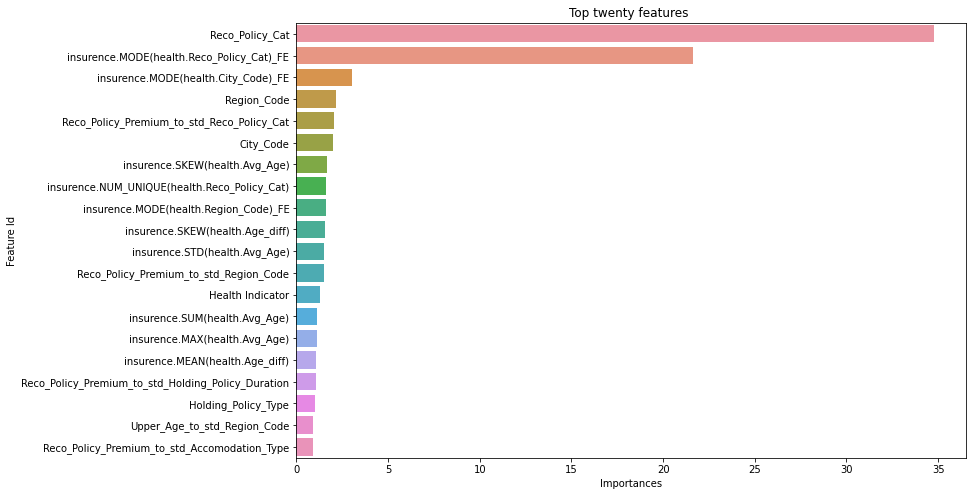

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(y='Feature Id', x='Importances',data=feature_importance_df, orient='h')
plt.title("Top twenty features ");

### submission file

In [140]:
y_test_pred_proba = model.predict_proba(X_test)[:,1] 

In [141]:
y_test_pred_proba.shape

(21805,)

In [142]:
test_df.shape

(21805, 16)

In [143]:
submission = pd.DataFrame()
submission['ID'] = test_df.ID.values
submission["Response"] = y_test_pred_proba

In [145]:
submission.to_csv('Catboost_with_further_fe_baseline_Ordered_increased_iteration_1700.csv', index=False)